# Set up

In [1]:
# Let us install timing extensions
try:
    %load_ext autotime
except:
    !pip install ipython-autotime
    %load_ext autotime

### Dependencies: 
graph_tool, networkx, spot, toytree, toyplot, cvxopt, skunk

In [2]:
from workspace import *
from high_level_monitor import *
from low_level_monitor import *
from predictive_intent_tree import *
from buchi import *
from himo import *
from buchi_with_AP import *
from processing_thor import *

import numpy as np
import skunk
import graph_tool.all as gt
import time
import pandas as pd
import matplotlib as mpl 
# mpl.use('cairo') 
import matplotlib.pyplot as plt
import scipy.optimize as sp
from collections import deque 
import toytree
import toyplot
import networkx as nx


(ipykernel_launcher.py:40635): Gtk-WARNING **: 21:49:12.975: Locale not supported by C library.
	Using the fallback 'C' locale.


time: 3.95 s


### Load Thor trajectory data

In [3]:
exp_id = 1
run_id = 1
agent = 'lab'
region_accept_dist = REGION_ACCEPT_DIST_LAB

time: 398 µs


In [4]:
# Reference
if exp_id == 1:
    agent_names = ['2','utility','4','5','6','7','8','lab','inspector','lidar','robot']
elif exp_id == 2:
    agent_names = ['utility','3','4','5','6','7','lab','9','inspector','lidar','robot']
elif exp_id == 3:
    agent_names = ['2','3','lab','utility','6','7','8','9','inspector','lidar','robot']

time: 630 µs


In [5]:
# traj_data = pd.read_csv(f'./Thor/exp{exp_id}-run{run_id}-{agent}.csv')
traj_data = pd.read_csv(f'./Thor/exp{exp_id}-run{run_id}-{agent}_with_goal.csv', usecols=['X', 'Y'])
traj_data = list(traj_data.itertuples(index=False, name=None))
goal_data = pd.read_csv(f'./Thor/exp{exp_id}-run{run_id}-{agent}_with_goal.csv', usecols=['G1', 'G2', 'G3']).values

time: 8.42 ms


In [6]:
# # Trajectory sampling to remove trash data
# traj_data = traj_data[::3]

time: 258 µs


### Map setting
- In this version, MAP_SIZE 'x' and 'y' should be the same.
- Starting position (0,0) is the left bottom of the map.

In [7]:
NUM_REGIONS = 6
MAP_SIZE, start_position = {'x': 100, 'y': 100}, traj_data[0]
print(start_position)

(46, 5)
time: 668 µs


### Workspace
- Regions are randomly generated.

In [8]:
ws = Workspace(MAP_SIZE, NUM_REGIONS, start_position)
# ------------------------------------------------------------------
# Useful vars
#     ws.region: coordinates of regions
#     ws.region_idx: cell indices of regions
# ------------------------------------------------------------------

time: 86.6 ms


- Or the user can manually define regions: **Workspace(MAP_SIZE, NUM_REGIONS, start_position, region = [(a, b), (c, d), ...])**

In [9]:
region = REGION
NUM_REGIONS = len(region)
ws = Workspace(MAP_SIZE, NUM_REGIONS, start_position, region = region)

time: 75.2 ms


- Remove wall and an obstacle

In [10]:
pre_obstacle = [(52, 23), (51, 23), (50, 24), (51, 24), (52, 24), (50, 25), (51, 25), (52, 25), (49, 23), (49, 24), (49, 25), (49, 22), (50, 22), (51, 22), (52, 22)]
ws.set_pre_defined_obstacle(pre_obstacle)


time: 1.75 ms


### Hypothetical missions
- LTL formulas for 'patrol', 'avoid', and 'patrol_while_avoid' missions can be automatically generated using region indices in each list. For example, if **['patrol', 0, 1]** is given to the monitor, **G (F p0 & F p1)** will be added to the intent set.

In [11]:
patrol = ['patrol', 0,1,2,3]
sequenced_patrol = ['seq_patrol', 1, 0]
ordered_patrol = ['ord_patrol', 1, 0]
avoid = ['avoid', 2]
patrol_while_avoid = ['patrol_while_avoid', patrol, avoid]
sequenced_patrol_while_avoid = ['seq_patrol_while_avoid', sequenced_patrol, avoid]
ordered_patrol_while_avoid = ['ord_patrol_while_avoid', ordered_patrol, avoid]

time: 721 µs


In [12]:
# ------------------------Three ground truth intents---------------------
# LTL_formula = [
#               ['patrol_while_avoid', ['patrol', 0, 1, 2, 3], ['avoid', 4, 5]], # visitor
#               ['seq_patrol_while_avoid', ['seq_patrol', 0, 2, 4], ['avoid', 1, 3, 5]], # lab
#               ['patrol_while_avoid', ['patrol', 1, 4], ['avoid', 0, 2, 3, 5]]] # utility

# ------------------------Three ground truth intents and ten arbitrary intents---------------------
LTL_formula = [
              ['patrol_while_avoid', ['patrol', 0, 1, 2, 3], ['avoid', 4, 5]], # visitor
              ['seq_patrol_while_avoid', ['seq_patrol', 0, 2, 4], ['avoid', 1, 3, 5]], # lab
              ['patrol_while_avoid', ['patrol', 1, 4], ['avoid', 0, 2, 3, 5]], # utility
              ['ord_patrol_while_avoid', ['ord_patrol', 0, 2], ['avoid', 1, 3, 4, 5]], # random1
              ['seq_patrol_while_avoid', ['seq_patrol', 3, 2], ['avoid', 0, 1, 4, 5]], # random2
              'G(p0 -> G(!p2)) & G(F(p0 & Fp3))', # random3
              ['patrol_while_avoid', ['patrol', 0, 1, 2, 3, 5], ['avoid', 4]], # random4
              ['patrol', 0, 1, 2], # random5
              ['patrol_while_avoid', ['patrol', 0, 2, 5], ['avoid', 1]], # random6
              'G(p0 -> G(!p2)) & G(F(p0 & Fp3)) & ( ! p2 U p0 )', # random7
              'G(p2 -> G(!p1 | !p0)) & G (F ( p2 & F p4)) & ( ! p4 U p2 ) & G ( p4 -> X ( ! p4 U p2)) & G ( p2 -> X ( ! p2 U p4))', # random8
              'G(p3 -> F(p0)) & G(F(p3 & F(p2 & Fp0))) & ( ! p3 U p2 )& ( ! p2 U p0 )', # random9
              ['seq_patrol', 0, 1, 2, 3, 4, 5]] # random10

# ------------------------Three ground truth intents and three arbitrary intents---------------------
LTL_formula = [
              ['patrol_while_avoid', ['patrol', 0, 1, 2, 3], ['avoid', 4, 5]], # visitor
              ['seq_patrol_while_avoid', ['seq_patrol', 0, 2, 4], ['avoid', 1, 3, 5]], # lab
              ['patrol_while_avoid', ['patrol', 1, 4], ['avoid', 0, 2, 3, 5]], # utility
              ['patrol', 0, 3], # random1
              ['ord_patrol_while_avoid', ['ord_patrol', 1, 2], ['avoid', 0, 3, 4, 5]], # random2
              'G(p1 -> F(p3)) & G!p5 & G(F(p1 & Fp0)) & ( ! p3 U p0 )'] # random3


time: 2.86 ms


### Monitor

Regions:  [(95, 40), (87, 18), (42, 3), (3, 20), (55, 40), (15, 36)]
-------------------------------------------------------------------
LTL: probability

0- 1: 0.06433636913747938
1- (F p0 & F p1 & F p2 & F p3) & G ! p4 & G ! p5: 0.04585382491051007
2- (F ( p0 & F ( p2 & F p4))) & G ! p1 & G ! p3 & G ! p5: 0.7648242852297781
3- (F p1 & F p4) & G ! p0 & G ! p2 & G ! p3 & G ! p5: 0.029854768241723367
4- (F p0 & F p3): 0.03479387160795858
5- G (F ( p1 & F p2)) & ( ! p2 U p1 ) & G ( p2 -> X ( ! p2 U p1)) & G ( p1 -> X ( ! p1 U p2)) & G ! p0 & G ! p3 & G ! p4 & G ! p5: 0.029854768241723367
6- G(p1 -> F(p3)) & G!p5 & G(F(p1 & Fp0)) & ( ! p3 U p0 ): 0.03048211263082694
-------------------------------------------------------------------
AP(immediate): probability

0: 0.12645419551715695
1: 0.09462473736283822
2: 0.010722728189579898
3: 0.053823442854152
4: 0.6939040027611021
5: 0.02047089331517087
-------------------------------------------------------------------
(47, 2)


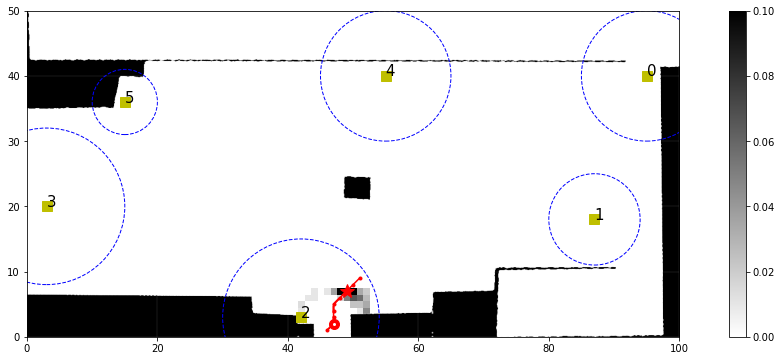

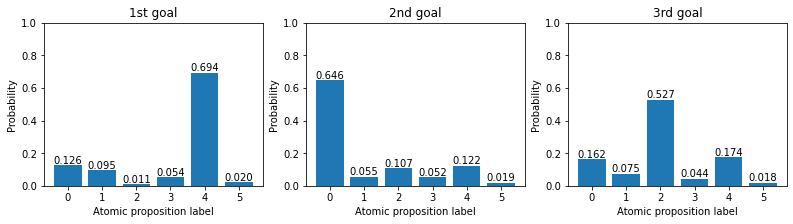

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="500.0px" height="500.0px" viewBox="0 0 500.0 500.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t93fec5d559904baea9f292e1e47f42e6"> idx: 0
dist: 1.0000
support: 0.0000
height: 0.0000
name: 191 4 idx: 1
dist: 1.0000
support: 0.0000
height: 0.0000
name: 189 2 idx: 2
dist: 1.0000
support: 0.0000
height: 2.0000
name: 1 0 idx: 3
dist: 1.0000
support: 0.0000
height: 1.0000
name: 31 0 idx: 4
dist: 1.0000
support: 0.0000
height: 2.0000
name: 5 4 (4, 0, 4): 0.1223 (4, 0, 2): 0.4996 (0,): 0.1265

time: 2.79 s


In [13]:
print("Regions: ", ws.region)
print("-------------------------------------------------------------------")
monitor = HIMO(LTL_formula, ws, alpha=5, beta_high=0.01, beta_low=3, epsilon=0.3, tree_depth=4)
n =110
monitor.add_observations_thor(traj_data[1:n], print_probab = True, accept_dist=region_accept_dist)

monitor.prediction(300,5)
monitor.plot_thor(traj_data[1:n+5], region_accept_dist, tree_prob_threshold=0.1, tree_height=500, tree_width=500)
print(traj_data[n-1])

---